In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import os

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
om_s8_list_fid = np.genfromtxt("om_s8_list_fid5000.txt", delimiter=",")
om_s8_list_swp = np.genfromtxt("om_s8_list_inference_swp3600x10.txt", delimiter=",")

In [452]:
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
z       = 0.5
af      = 1.0 / (1.0 + z)       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 10        #number of time-steps to split the total evolution into
L       = 256       #Physical size of the Universe in Mpc/h
N       = 160        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 1         #Batch size, how many independent Universes to simulate

arg_k_ = 5
res_len = 64

vec_fid = []
for i in range(om_s8_list_fid.shape[0]):
    vec_fid.append(np.load("inference_fid5000_swp10000x1/vecGen/fs_{}_{}_{}_{}_{}_{}_{}_{}_fid_{}_{}_{}.npy".format(str(np.round(om_s8_list_fid[i,0], decimals=6)), str(np.round(om_s8_list_fid[i,1], decimals=6)), a0, z, n_steps, L, N, batch, str(int(om_s8_list_fid[i,-1])), arg_k_, res_len)))

vec_swp = []
for i in range(om_s8_list_swp.shape[0]):
    if os.path.isfile("inference_swp900x10/vecGen/fs_{}_{}_{}_{}_{}_{}_{}_{}_swp_{}_{}_{}.npy".format(str(np.round(om_s8_list_swp[i,0], decimals=6)), str(np.round(om_s8_list_swp[i,1], decimals=6)), a0, z, n_steps, L, N, batch, str(int(om_s8_list_swp[i,-1])), arg_k_, res_len)):
        vec_swp.append(np.load("inference_swp900x10/vecGen/fs_{}_{}_{}_{}_{}_{}_{}_{}_swp_{}_{}_{}.npy".format(str(np.round(om_s8_list_swp[i,0], decimals=6)), str(np.round(om_s8_list_swp[i,1], decimals=6)), a0, z, n_steps, L, N, batch, str(int(om_s8_list_swp[i,-1])), arg_k_, res_len)))
    else:
        vec_swp.append(np.load("inference_swp3600x10-900x10/vecGen/fs_{}_{}_{}_{}_{}_{}_{}_{}_swp_{}_{}_{}.npy".format(str(np.round(om_s8_list_swp[i,0], decimals=6)), str(np.round(om_s8_list_swp[i,1], decimals=6)), a0, z, n_steps, L, N, batch, str(int(om_s8_list_swp[i,-1])), arg_k_, res_len)))

N_cov = 4990
# ind = np.concatenate((np.arange(0,res_len*3),np.arange(res_len*6,res_len*9)))  # B+D
ind = np.concatenate((np.arange(0,res_len*3),np.arange(res_len*3,res_len*6)))  # B+P
vec_cov_raw = np.array(vec_fid)[:N_cov,ind]
vec_fid_raw = np.array(vec_fid)[N_cov:,ind]
vec_swp_raw = np.array(vec_swp)[:,ind]

In [655]:
vec_cov = vec_cov_raw
vec_fid = vec_fid_raw
vec_swp = vec_swp_raw

In [656]:
swp_mul = 10
avg_over = 10
vec_fid = np.array([np.mean(vec_fid, axis=0)])

dummy = []
for i in range(int(vec_cov.shape[0]/swp_mul)):
    dummy.append(np.mean(vec_cov[i*swp_mul:i*swp_mul+avg_over,:], axis=0))
vec_cov = np.array(dummy)

dummy = []
for i in range(int(vec_swp.shape[0]/swp_mul)):
    dummy.append(np.mean(vec_swp[i*swp_mul:i*swp_mul+avg_over,:], axis=0))
vec_swp = np.array(dummy)

print(vec_cov.shape)
print(vec_fid.shape)
print(vec_swp.shape)

(499, 384)
(1, 384)
(3600, 384)


In [657]:
def res_changer(vec_high_res, res_len_low):
    sum_width = int(vec_high_res.shape[1]/res_len_low)
    print(sum_width)
    vec_low_res = np.zeros((vec_high_res.shape[0], res_len_low))
    for i in range(vec_high_res.shape[0]):
        for j in range(res_len_low):
            vec_low_res[i,j] = np.sum(vec_high_res[i,j*sum_width:(j+1)*sum_width])
    
    return vec_low_res

In [658]:
# Raw res is 64*3*2=576
res_len_low = 96
vec_cov = res_changer(vec_cov, res_len_low)
vec_fid = res_changer(vec_fid, res_len_low)
vec_swp = res_changer(vec_swp, res_len_low)

4
4
4


In [659]:
# empty_col = []
# for i in range(vec_cov.shape[1]):
#     if np.sum(vec_cov[:,i]) == 0:
#         empty_col.append(i)
# print(empty_col)
# empty_col = np.array(empty_col)

# non_empty_col = np.delete(np.arange(vec_cov.shape[1]), empty_col)
# print(non_empty_col.shape)

# vec_cov = vec_cov[:,non_empty_col]
# vec_fid = vec_fid[:,non_empty_col]
# vec_swp = vec_swp[:,non_empty_col]

In [660]:
print(vec_cov.shape)
print(vec_fid.shape)
print(vec_swp.shape)

(499, 96)
(1, 96)
(3600, 96)


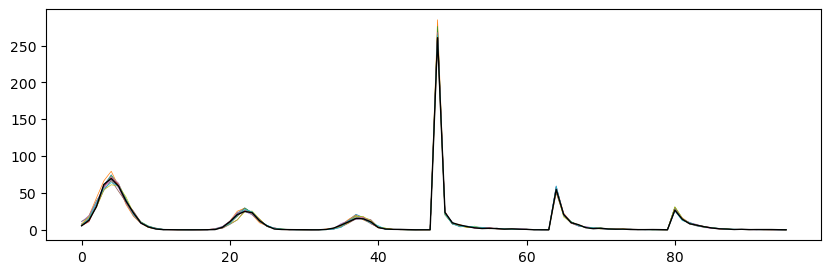

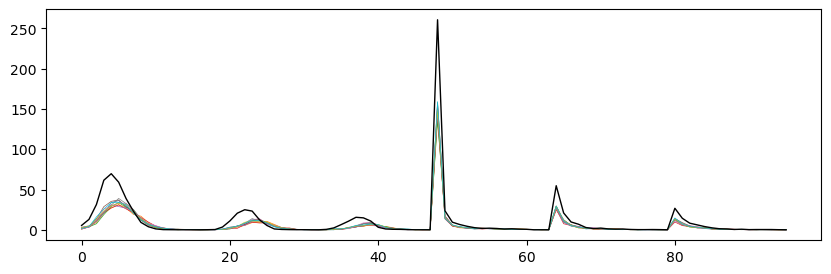

In [661]:
# plt.figure(figsize=(20,3))
# for i in range(10):
#     plt.plot(np.arange(vec_cov.shape[1]), vec_cov[i,:], lw=0.5)
# plt.plot(np.arange(vec_cov.shape[1]), np.mean(vec_fid, axis=0), lw=2, c="black")
# plt.show()

# plt.figure(figsize=(20,5))
# for i in range(10):
#     plt.plot(np.arange(vec_cov.shape[1]), np.mean(vec_fid[i*10:(i+1)*10,:], axis=0), lw=0.5)
# plt.plot(np.arange(vec_cov.shape[1]), np.mean(vec_fid, axis=0), lw=1.5, c="black")
# plt.show()

# plt.figure(figsize=(20,5))
# for i in range(10):
#     plt.plot(np.arange(vec_swp.shape[1]), vec_swp[np.random.choice(np.arange(10000)),:], lw=0.5)
# plt.plot(np.arange(vec_cov.shape[1]), np.mean(vec_fid, axis=0), lw=1.5, c="black")
# plt.show()

plt.figure(figsize=(10,3))
for i in range(10):
    plt.plot(np.arange(vec_cov.shape[1]), vec_cov[i,:], lw=0.5)
plt.plot(np.arange(vec_cov.shape[1]), vec_fid[0], lw=1, c="black")
plt.show()

plt.figure(figsize=(10,3))
for i in range(10):
    plt.plot(np.arange(vec_swp.shape[1]), vec_swp[i,:], lw=0.5)
plt.plot(np.arange(vec_cov.shape[1]), vec_fid[0], lw=1, c="black")
plt.show()

In [662]:
cov = np.cov(vec_cov.T)
corr = np.corrcoef(vec_cov.T)
print(0 in cov)
print(np.linalg.det(cov))

False
1.0035531629535506e-98


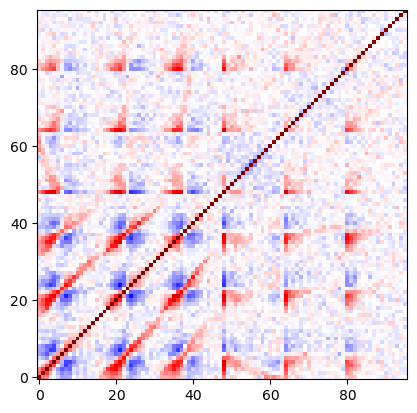

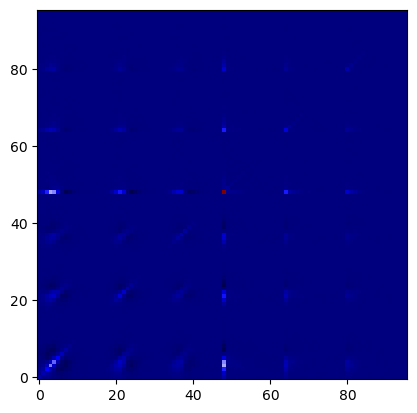

In [663]:
plt.imshow(corr, origin='lower', cmap='seismic', norm=mpl.colors.Normalize(vmin=-1, vmax=1))
plt.show()

plt.imshow(cov, origin='lower', cmap='seismic', norm=mpl.colors.Normalize())
plt.show()

In [664]:
def ln_Gaussian_likelihood_no_norm(x, x_fid, cov):
    power = -0.5*np.matmul(np.matmul(x-x_fid, np.linalg.inv(cov)), x-x_fid)
    return power

In [665]:
# plt.imshow([[1,1],[100,200]],origin='lower')
# plt.show()

In [666]:
post = np.zeros((int(np.sqrt(vec_swp.shape[0])),int(np.sqrt(vec_swp.shape[0]))))
for i in range(vec_swp.shape[0]):
    if i % 100 == 0:
        print(i)
    post[int(i%int(np.sqrt(vec_swp.shape[0]))), int(i/int(np.sqrt(vec_swp.shape[0])))] = ln_Gaussian_likelihood_no_norm(vec_swp[i], vec_fid[0], cov)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


In [667]:
# print(post)
# print(np.amax(post))
# print(post+np.abs(np.amin(post)))
# print(post)
# np.save("post", post)

# plt.imshow(post, origin='lower', cmap='seismic', norm=mpl.colors.Normalize())
# plt.title("~ln(posterior)")
# plt.ylabel("s8")
# plt.xlabel("om")
# plt.xticks(np.linspace(0,29,5,endpoint=True), np.around(np.linspace(0.2589,0.3589,5,endpoint=True), decimals=3))
# plt.yticks(np.linspace(0,29,5,endpoint=True), np.around(np.linspace(0.7659,0.8659,5,endpoint=True), decimals=3))
# plt.show()

In [668]:
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Make data.
# X = np.arange(0,30)
# Y = np.arange(0,30)
# X, Y = np.meshgrid(X, Y)
# Z = post

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# # ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.view_init(elev=50, azim=250)
# plt.show()

In [669]:
def ln_gauss2d_no_norm(xy, x0, y0, a, c, b):  # a, c, b are from the inverse of the covariance matrix
    x, y = xy
    inner = a * (x - x0)**2
    inner += 2 * c * (x - x0) * (y - y0)
    inner += b * (y - y0)**2
    return -0.5*inner

In [670]:
x = []
y = []
for i in range(60):
    for j in range(60):
        y.append(i)
        x.append(j)
xy = (x, y)

z = post.flatten()

i = z.argmax()
# guess = [x[i], y[i], 1, 1, 1]
guess = [35, 25, 0.1, 0.1, 0.1]
pred_params, uncert_cov = curve_fit(ln_gauss2d_no_norm, xy, z, p0=guess, maxfev=999999999)
print(pred_params)
print(uncert_cov)

[30.90104353 24.01987395  0.62613013  0.15869578  0.3841167 ]
[[ 1.77666865e-02 -1.88451294e-02 -8.33297898e-05  1.45747755e-04
  -1.94541125e-04]
 [-1.88451294e-02  5.23563344e-02 -1.41956122e-04 -1.10929521e-04
   8.77584760e-04]
 [-8.33297898e-05 -1.41956122e-04  4.23848919e-05 -2.54277657e-07
  -2.23557212e-05]
 [ 1.45747755e-04 -1.10929521e-04 -2.54277657e-07  1.33994603e-05
  -2.30317480e-07]
 [-1.94541125e-04  8.77584760e-04 -2.23557212e-05 -2.30317480e-07
   4.68171271e-05]]


In [671]:
cov_inv_pred = np.array([[pred_params[2], pred_params[3]], [pred_params[3], pred_params[4]]])
cov_pred = np.linalg.inv(cov_inv_pred)
mean_pred = np.array([pred_params[0], pred_params[1]])
print(mean_pred[0]*(0.4089-0.2089)/60+0.2089)
print(mean_pred[1]*(0.9159-0.7159)/60+0.7159)
print(np.sqrt(cov_pred[0,0])*(0.4089-0.2089)/60)
print(np.sqrt(cov_pred[1,1])*(0.9159-0.7159)/60)
mean_pred_param_space = np.array([pred_params[0]*(0.4089-0.2089)/60+0.2089, pred_params[1]*(0.9159-0.7159)/60+0.7159])
cov_pred_param_space = np.array([[(np.sqrt(cov_pred[0,0])*(0.4089-0.2089)/60)**2, cov_pred[0,1]*((0.4089-0.2089)/60)*((0.9159-0.7159)/60)], [cov_pred[0,1]*((0.4089-0.2089)/60)*((0.9159-0.7159)/60), (np.sqrt(cov_pred[1,1])*(0.9159-0.7159)/60)**2]])
print(mean_pred_param_space)
print(cov_pred_param_space)
print(np.linalg.inv(cov_pred_param_space))

0.31190347844170613
0.7959662465141153
0.004452105428337294
0.005684158102241716
[0.31190348 0.79596625]
[[ 1.98212427e-05 -8.18904126e-06]
 [-8.18904126e-06  3.23096533e-05]]
[[56351.71201717 14282.61981487]
 [14282.61981487 34570.50286296]]


-762.0533134813933 -71.78530045037


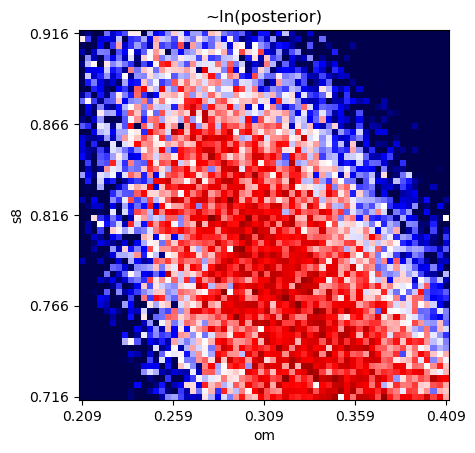

(60, 60)


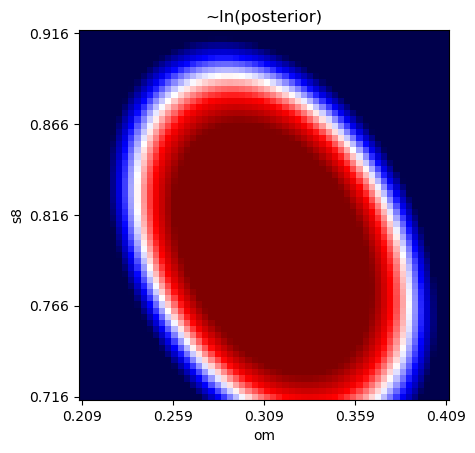

In [672]:
print(np.amin(post),np.amax(post))
plt.imshow(post, origin='lower', cmap='seismic', norm=mpl.colors.Normalize(-250,np.amax(post)))
plt.title("~ln(posterior)")
plt.ylabel("s8")
plt.xlabel("om")
plt.xticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.2089,0.4089,5,endpoint=True), decimals=3))
plt.yticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.7159,0.9159,5,endpoint=True), decimals=3))
plt.show()

x = []
y = []
for i in range(60):
    for j in range(60):
        y.append(i)
        x.append(j)
z = post.flatten()
xy = (x, y)
z_pred = ln_gauss2d_no_norm(xy, *pred_params)
z_pred = np.array(z_pred).reshape(60,60)
print(z_pred.shape)
plt.imshow(z_pred, origin='lower', cmap='seismic', norm=mpl.colors.Normalize(-200,np.amax(post)))
plt.title("~ln(posterior)")
plt.ylabel("s8")
plt.xlabel("om")
plt.xticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.2089,0.4089,5,endpoint=True), decimals=3))
plt.yticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.7159,0.9159,5,endpoint=True), decimals=3))
plt.show()

In [673]:
def gauss2d(xy, mean, cov):
    x, y = xy
    x0 = mean[0]
    y0 = mean[1]
    inner = np.linalg.inv(cov)[0,0] * (x - x0)**2
    inner += 2 * np.linalg.inv(cov)[0,1] * (x - x0) * (y - y0)
    inner += np.linalg.inv(cov)[1,1] * (y - y0)**2
    return np.exp(-0.5*(inner + 2*np.log(2*np.pi) + np.log(np.linalg.det(cov))))

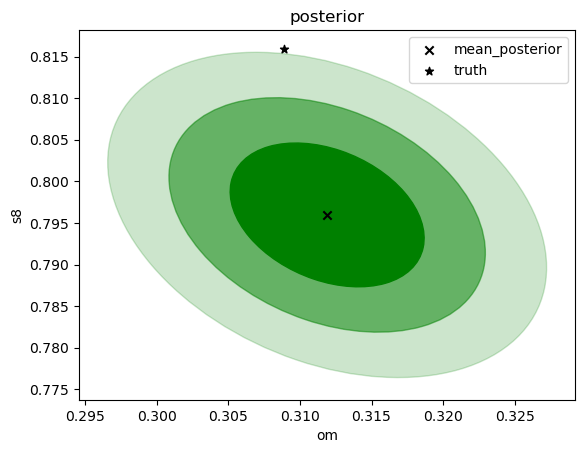

In [674]:
# x = []
# y = []
# for i in np.linspace(11,15,100):
#     for j in np.linspace(12,16,100):
#         y.append(i)
#         x.append(j)
# xy = (x, y)
# z_pred = gauss2d(xy, mean_pred, cov_pred)
# z_pred = np.array(z_pred).reshape(100,100)
# print(z_pred.shape)
# plt.imshow(z_pred, origin='lower', cmap='viridis', norm=mpl.colors.Normalize())
# plt.scatter((mean_pred[0]-12)/(16-12)*100, (mean_pred[1]-11)/(15-11)*100)
# plt.title("posterior")
# plt.ylabel("s8")
# plt.xlabel("om")
# plt.xticks(np.linspace(0,99,5,endpoint=True), np.around(np.linspace(0.2589+(0.3589-0.2589)/30*12,0.2589+(0.3589-0.2589)/30*16,5,endpoint=True), decimals=3))
# plt.yticks(np.linspace(0,99,5,endpoint=True), np.around(np.linspace(0.7659+(0.8659-0.7659)/30*11,0.7659+(0.8659-0.7659)/30*15,5,endpoint=True), decimals=3))
# plt.show()

# xc, yc = np.mgrid[0.290:0.320:0.0001, 0.800:0.820:0.0001]
# rv = multivariate_normal(mean_pred_param_space, cov_pred_param_space)
# zc = rv.pdf(np.dstack((xc, yc)))
# plt.contourf(xc, yc, zc, cmap='viridis')

fig, ax = plt.subplots()

a2 = (cov_pred_param_space[0,0] + cov_pred_param_space[1,1]) / 2 + np.sqrt((cov_pred_param_space[0,0] - cov_pred_param_space[1,1])**2 / 4 + cov_pred_param_space[0,1]**2)
b2 = (cov_pred_param_space[0,0] + cov_pred_param_space[1,1]) / 2 - np.sqrt((cov_pred_param_space[0,0] - cov_pred_param_space[1,1])**2 / 4 + cov_pred_param_space[0,1]**2)
tan2th = 2 * cov_pred_param_space[0,1] / (cov_pred_param_space[0,0] - cov_pred_param_space[1,1])
a = np.sqrt(a2)
b = np.sqrt(b2)
th = np.degrees(np.arctan(tan2th) / 2)
th = np.degrees(np.arctan2(2 * cov_pred_param_space[0,1], cov_pred_param_space[0,0] - cov_pred_param_space[1,1]) / 2)
alpha = [0, 1.52, 2.48, 3.44]
ellipse = Ellipse(xy=(mean_pred_param_space[0], mean_pred_param_space[1]), width=alpha[3]*a*2, height=alpha[3]*b*2, angle=th, color="green", alpha=0.2)
ax.add_patch(ellipse)
ellipse = Ellipse(xy=(mean_pred_param_space[0], mean_pred_param_space[1]), width=alpha[2]*a*2, height=alpha[2]*b*2, angle=th, color="green", alpha=0.5)
ax.add_patch(ellipse)
ellipse = Ellipse(xy=(mean_pred_param_space[0], mean_pred_param_space[1]), width=alpha[1]*a*2, height=alpha[1]*b*2, angle=th, color="green", alpha=1)
ax.add_patch(ellipse)

plt.scatter(mean_pred_param_space[0], mean_pred_param_space[1], marker="x", color="black", label="mean_posterior")
plt.scatter(0.3089, 0.8159, marker="*", color="black", label="truth")
plt.title("posterior")
plt.ylabel("s8")
plt.xlabel("om")
plt.legend()
plt.show()